In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for density plots
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('520_normalizes.keras')

# Load the data from the SQLite database
conn = sqlite3.connect('../../../../data/nfp2/nfp2_combined.db')  # Adjust the path to your database file
query = "SELECT * FROM stellarators_combined"  # Adjust your query as needed
data_df = pd.read_sql_query(query, conn)
conn.close()

# Clean the data
data_df_clean = data_df[data_df['convergence'] == 1]
data_df_clean = data_df_clean.dropna(subset=['quasisymmetry'])

# Define features (X) and target (Y)
X = data_df_clean[['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1', 'zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']]
Y = np.log(data_df_clean['quasisymmetry'])

# Normalize the features and target
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y.values.reshape(-1, 1)).flatten()

# Split the data into training and testing sets
features_no_outliers, test_features_no_outliers, target_no_outliers, test_target_no_outliers = train_test_split(
    X_scaled, Y_scaled, test_size=0.2, random_state=42)

2024-11-30 17:44:40.082410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 17:44:40.098763: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 17:44:40.103381: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 17:44:40.123110: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-30 17:44:40.968979: W tensorflow/compiler/tf2

  77/2859 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step 

2859/2859 ━━━━━━━━━━━━━━━━━━━━ 2s 583us/step
Mean Squared Error: 0.009174267073666548
R^2 Score: 0.990881564748891


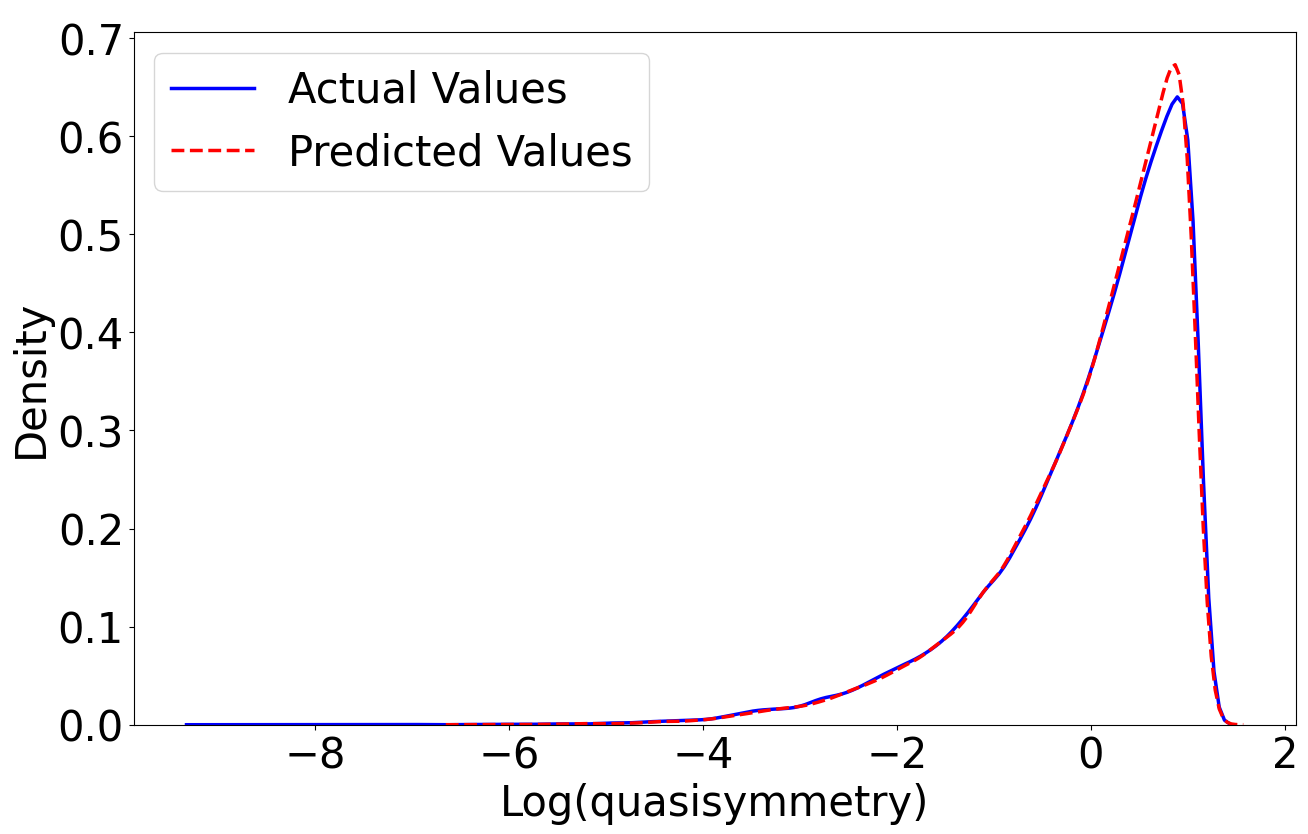

In [2]:
# Make predictions on the test set
predictions = model.predict(test_features_no_outliers).flatten()

# Evaluate the model
mse = mean_squared_error(test_target_no_outliers, predictions)
r2 = r2_score(test_target_no_outliers, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot density plots for predicted and actual values
plt.figure(figsize=(15, 9))

# Plot density for actual values
sns.kdeplot(test_target_no_outliers, label='Actual Values', color='blue', fill=False, linewidth=2.5)

# Plot density for predicted values
sns.kdeplot(predictions, label='Predicted Values', color='red', fill=False, linewidth=2.5, linestyle='--')

plt.xlabel('Log(quasisymmetry)', fontsize = 30)
plt.ylabel('Density', fontsize = 30)
plt.title(' ')
plt.legend(fontsize = 30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.savefig('qs_density_nn2.pdf')
plt.show()

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams

# Set global matplotlib font sizes
rcParams.update({
    'font.size': 23,            # Base font size
    'axes.titlesize': 23,       # Axis title font size
    'axes.labelsize': 23,       # Axis label font size
    'xtick.labelsize': 23,      # X-tick font size
    'ytick.labelsize': 23,      # Y-tick font size
    'legend.fontsize': 23,      # Legend font size
    'figure.titlesize': 23      # Figure title font size
})

# Define a function to get a smaller random sample from the dataset
def get_background_data(X, sample_size=100):
    np.random.seed(42)
    sample_indices = np.random.choice(X.index, size=min(sample_size, len(X)), replace=False)
    return X.loc[sample_indices]

# Assuming features_no_outliers and test_features_no_outliers are loaded properly
background = get_background_data(pd.DataFrame(features_no_outliers), sample_size=1)

# Define the prediction function
def predict_fn(X):
    return model.predict(X).flatten()

# Create the SHAP explainer with the background data
explainer = shap.KernelExplainer(predict_fn, background)

# Define a consistent sample size for SHAP values and test data
sample_size = 10000  # Adjust if needed
test_sample = test_features_no_outliers[:sample_size]

# Compute SHAP values
shap_values = explainer.shap_values(test_sample)

# Define the feature names
feature_names = ['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1', 'zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']

# Plot SHAP summary plot
fig = plt.figure(figsize=(15, 8))  # Increase the figure size
shap.summary_plot(
    shap_values,
    test_sample,
    feature_names=feature_names,
    show=False
)

# Customize font sizes for axes, labels, and ticks
ax = plt.gca()  # Get current axes
ax.set_title(ax.get_title(), fontsize=23)  # Adjust title font size
ax.set_xlabel(ax.get_xlabel(), fontsize=23)  # Adjust x-axis label font size
ax.set_ylabel(ax.get_ylabel(), fontsize=23)  # Adjust y-axis label font size
ax.tick_params(axis='x', labelsize=23)  # Adjust x-tick font size
ax.tick_params(axis='y', labelsize=23)  # Adjust y-tick font size

# Adjust colorbar ticks and labels
colorbar = plt.gcf().get_axes()[-1]  # SHAP places the colorbar as the last axes
colorbar.tick_params(labelsize=23)  # Adjust colorbar tick font size
colorbar.set_ylabel("Feature value", fontsize=23)  # Adjust colorbar label size

# Explicitly adjust "High" and "Low" font sizes
colorbar_labels = colorbar.get_yticklabels()  # Get colorbar labels
colorbar_labels[0].set_fontsize(23)  # Low
colorbar_labels[-1].set_fontsize(23)  # High
colorbar.set_yticklabels(['Low', 'High'], fontsize=23)  # Reapply with font size

# Save the plot with adjusted layout
plt.tight_layout()
plt.savefig('qs_best_features_nn_centered.pdf', format='pdf')
#plt.close()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step